# <span style='font-family:Futura;font-weight:bold'>NOTEBOOK 6</span>

---

This notebook contains the codes used during the sixth lecture of the course <span style='color:SlateBlue;font-style:italic'>"Modelling from Measurements"</span>.

## <span style='font-family:Futura;font-weight:bold'>Exercise 6.1</span>

In the first exercise we will solve a computer vision problem.

In [1]:
#%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import rcParams, cm
from matplotlib import animation
import sklearn
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from matplotlib.colors import LightSource
from scipy import interpolate

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Palatino"

First of all we have to import the data from the folder 'data/'. The scipy method loadmat allows to import the '.mat' file as a dictionary.

In [2]:
dogData_w = loadmat('data/dogData_w.mat')
catData_w = loadmat('data/catData_w.mat')

dog_wave = dogData_w['dog_wave']
cat_wave = catData_w['cat_wave']

Now we have to build our training and test sets.

In [3]:
train = np.concatenate((dog_wave[:, :60], cat_wave[:, :60]),axis=1)
test = np.concatenate((dog_wave[:, 60:], cat_wave[:, 60:]),axis=1)
label = np.repeat(np.array([1,-1]), 60)

Let's compute the pseudoinverse.

In [4]:
A = label @ np.linalg.pinv(train)
test_labels = np.sign(A @ test)

Text(0.5, 1.0, 'PSEUDOINVERSE')

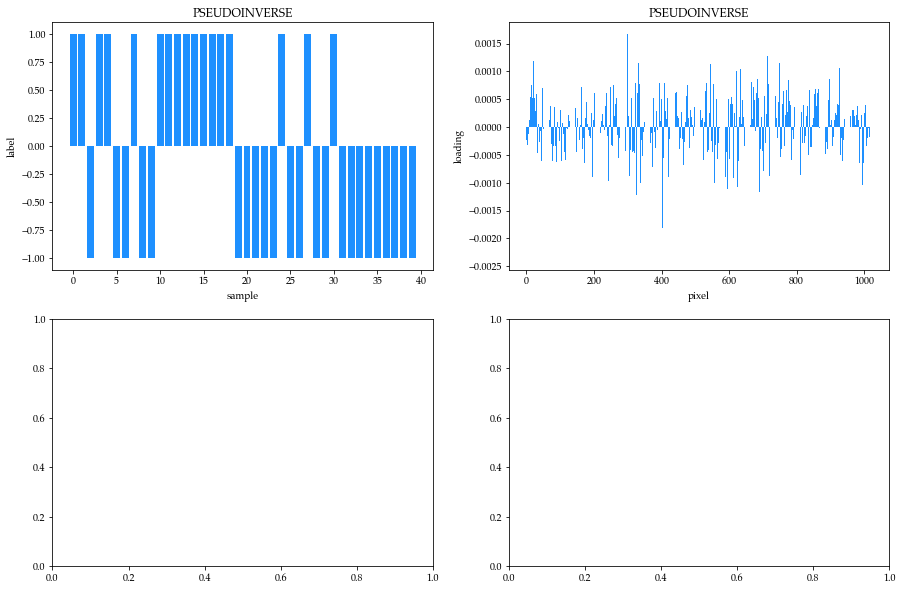

In [5]:
fig1 = plt.figure(figsize=(15, 10))
ax1 = [fig1.add_subplot(2, 2, k) for k in range(1,5)]

ax1[0].bar(range(len(test_labels)),test_labels, color='dodgerblue')
ax1[0].set_ylabel('label'), ax1[0].set_xlabel('sample')
ax1[0].set_title('PSEUDOINVERSE')
ax1[1].bar(range(len(A)),A, color='dodgerblue')
ax1[1].set_ylabel('loading'), ax1[1].set_xlabel('pixel')
ax1[1].set_title('PSEUDOINVERSE')

In [6]:
plt.close()

Text(0.5, 1.0, 'PSEUDOINVERSE')

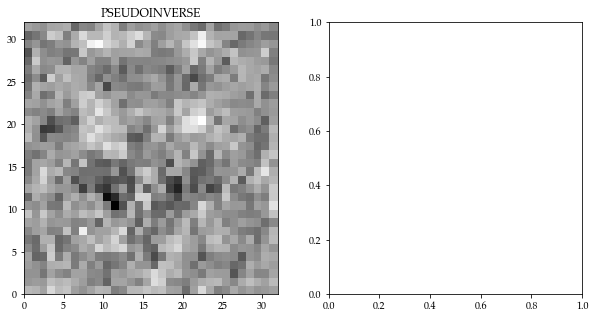

In [7]:
fig2 = plt.figure(figsize=(10, 5))
ax2 = [fig2.add_subplot(1, 2, k) for k in range(1,3)]
A2 = np.flipud(np.reshape(A, (32, 32))) # reshape and flip
ax2[0].pcolor(np.rot90(A2), cmap='gray')
ax2[0].set_title('PSEUDOINVERSE')

In [8]:
plt.close()

Let's do the same but with Lasso algorithm.

In [9]:
A = Lasso(alpha=0.1).fit(train.T, label)
test_labels = np.sign(A.coef_ @ test)

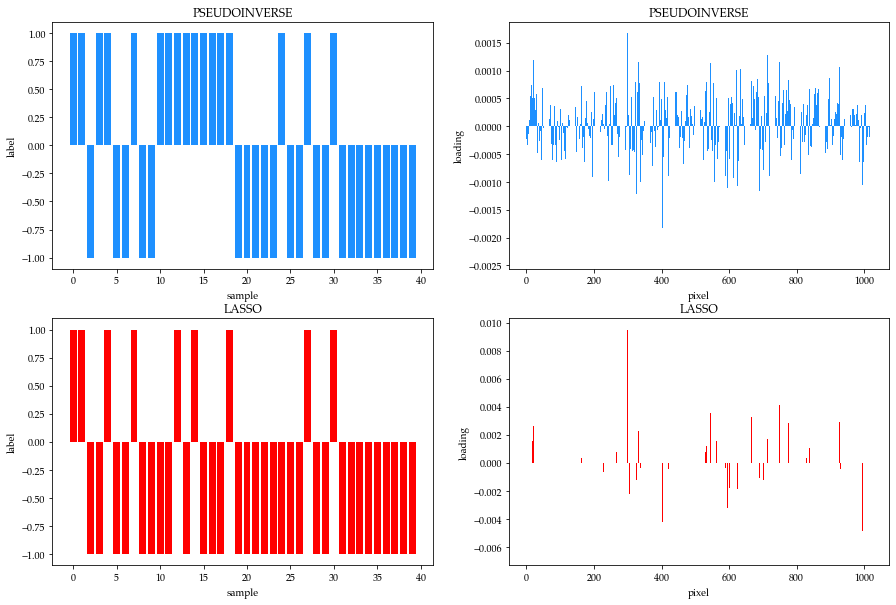

In [10]:
ax1[2].bar(range(len(test_labels)), test_labels, color='r')
ax1[2].set_ylabel('label'), ax1[2].set_xlabel('sample')
ax1[2].set_title('LASSO')
ax1[3].bar(range(len(A.coef_)), A.coef_, color='r')
ax1[3].set_ylabel('loading'), ax1[3].set_xlabel('pixel')
ax1[3].set_title('LASSO')
fig1

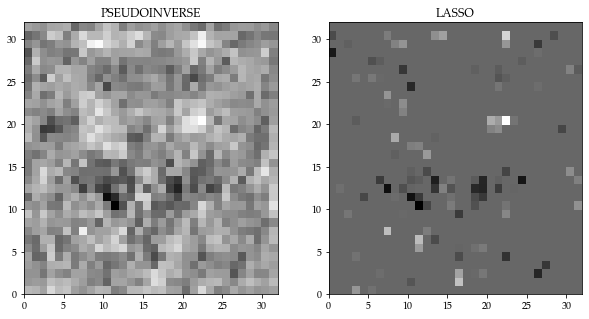

In [11]:
A2 = np.flipud(np.reshape(A.coef_, (32, 32))) # reshape and flip
ax2[1].pcolor(np.rot90(A2), cmap='gray')
ax2[1].set_title('LASSO')
fig2

## <span style='font-family:Futura;font-weight:bold'>Exercise 6.2</span>

In this exercise a simple application of the stochastic gradient descent will be considered.

In [12]:
h = 0.1
epochs = 100
x_grid = np.linspace(-6, 6, 12 / h + 1)
y_grid = np.linspace(-6, 6, 12 / h + 1)
n = len(x_grid)
 
X, Y = np.meshgrid(x_grid, y_grid) # mesh

F1 = 1.5 - 1.6 * np.exp(-0.05 * (3 * np.power(X + 3, 2) + np.power(Y + 3, 2)))
F = F1 + (0.5 - np.exp(-0.1 * (3 * np.power(X - 3, 2) + np.power(Y - 3, 2))))
dFy, dFx = np.gradient(F, h, h)

x0 = np.array([4, 0, -5]) # initialization
y0 = np.array([0, -5, 2]) # initialization

x = np.zeros((epochs + 1, 3))
y = np.zeros((epochs + 1, 3))
f = np.zeros((epochs + 1, 3))

In [13]:
for i in range(3):
    
    q = np.random.permutation(n) # shuffle sample indexes
    i1 = np.sort(q[:10])
    q2 = np.random.permutation(n)
    i2 = np.sort(q2[:10])
    x[0, i] = x0[i]
    y[0, i] = y0[i]
    
    X_tmp = np.tile(X[i1, i2],(10,1))
    Y_tmp = np.tile(np.reshape(Y[i1, i2], (-1,1)),(1,10))
    
    F_tmp = [F[i, j] for i in i1 for j in i2]
    F_tmp = np.reshape(F_tmp, (10, 10))
    dFy_tmp = [dFy[i, j] for i in i1 for j in i2]
    dFy_tmp = np.reshape(dFy_tmp, (10, 10))
    dFx_tmp = [dFx[i, j] for i in i1 for j in i2]
    dFx_tmp = np.reshape(dFx_tmp, (10, 10))

    f_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], F_tmp, kind='linear')
    dfx_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], dFx_tmp, kind='linear')
    dfy_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], dFy_tmp, kind='linear')

    f[0, i] = f_interp(x[0, i], y[0, i])
    dfx = dfx_interp(x[0, i], y[0, i])
    dfy = dfy_interp(x[0, i], y[0, i])

    tau = 0.2 # learning rate
    
    for epoch in range(epochs):
        
        x[epoch+1, i] = x[epoch, i] - tau * dfx
        y[epoch+1, i] = y[epoch, i] - tau * dfy
        q = np.random.permutation(n)
        i1 = np.sort(q[:10])
        q2 = np.random.permutation(n)
        i2 = np.sort(q2[:10])
        
        x_tmp = X[i1, i2]
        y_tmp = Y[i1, i2]

        F_tmp = [F[i, j] for i in i1 for j in i2]
        F_tmp = np.reshape(F_tmp, (10, 10))
        dFy_tmp = [dFy[i, j] for i in i1 for j in i2]
        dFy_tmp = np.reshape(dFy_tmp, (10, 10))
        dFx_tmp = [dFx[i, j] for i in i1 for j in i2]
        dFx_tmp = np.reshape(dFx_tmp, (10, 10))
        
        f_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], F_tmp, kind='linear')
        dfx_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], dFx_tmp, kind='linear')
        dfy_interp = interpolate.interp2d(X[i1, i2], Y[i1, i2], dFy_tmp, kind='linear')
        
        f[epoch+1, i] = f_interp(x[epoch+1, i], y[epoch+1, i])
        dfx = dfx_interp(x[epoch+1, i], y[epoch+1, i])
        dfy = dfy_interp(x[epoch+1, i], y[epoch+1, i])
        
        if np.abs(f[epoch+1, i] - f[epoch, i]) < 10**(-6): # check convergence
            print('Converged after {} iterations'.format(epoch+1))
            break
        if epoch == epochs-1:
            print('Failed to converge after {} iterations'.format(epoch+1))

Failed to converge after 100 iterations
Failed to converge after 100 iterations
Failed to converge after 100 iterations


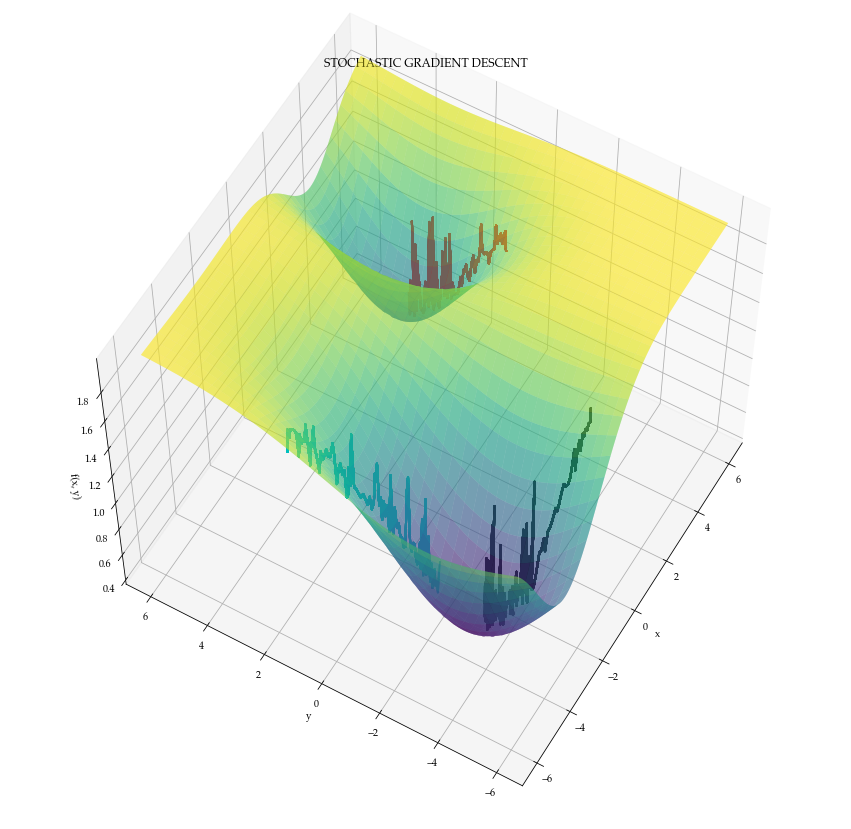

In [14]:
colors = ['r', 'k', 'c']
fig3 = plt.figure(figsize=(15,15))
ax3 = fig3.gca(projection='3d')
light = LightSource(90, 45)
illuminated_surface = light.shade(F, cmap=cm.viridis)
ax3.set_title('STOCHASTIC GRADIENT DESCENT')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('f(x, y)')

def init():
    surf = ax3.plot_surface(X, Y, F, cmap=cm.viridis, shade=False, alpha=0.4)
    surf.set_facecolor((0,0,0,0))
    ax3.view_init(elev=60., azim=210)
    return fig3,

def animate(i):
    ax3.plot(x[:i, 0], y[:i, 0], f[:i, 0], color=colors[0], linewidth='2')
    ax3.plot(x[:i, 1], y[:i, 1], f[:i, 1], color=colors[1], linewidth='2')
    ax3.plot(x[:i, 2], y[:i, 2], f[:i, 2], color=colors[2], linewidth='2')
    return fig3,

ani = animation.FuncAnimation(fig3, animate, init_func=init,
                               frames=len(x), interval=len(x), blit=True)

ani.save('SGD3d.gif', writer='imagemagick', fps=1000/len(x))

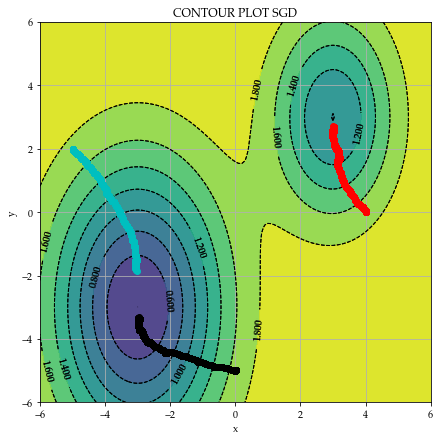

In [15]:
fig4 = plt.figure(figsize=(7,7))
ax4 = fig4.gca()
ax4.grid()
ax4.set_title('CONTOUR PLOT SGD')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

def init():
    # Plot the surface.
    cp = ax4.contour(X, Y, F, linestyles='dashed', linewidths=1, colors='k')
    plt.clabel(cp, inline=1, fontsize=10)
    cp = ax4.contourf(X, Y, F, alpha = 0.7)
    return fig4,

def animate(i):
    ax4.plot(x[:i, 0], y[:i, 0], '-o', color=colors[0], linewidth='2')
    ax4.plot(x[:i, 1], y[:i, 1], '-o', color=colors[1], linewidth='2')
    ax4.plot(x[:i, 2], y[:i, 2], '-o', color=colors[2], linewidth='2')
    return fig4,

ani = animation.FuncAnimation(fig4, animate, init_func=init,
                               frames=len(x), interval=len(x), blit=True)

ani.save('SGD2d.gif',writer='imagemagick',fps=1000/len(x))